In [1]:
%matplotlib inline
%matplotlib nbagg

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.nn.parameter import Parameter
import torch.nn.init as init
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, softmax

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import random
from collections import defaultdict
import pickle

from typing import *
from IPython.display import Image, display, clear_output

from plotting import make_vae_plots
from Code.Dataloader import batch_loader
from Code.MakeDict import findEDF
from Code.MNEplotter import MNEPlotter,plot_AC, plot_2d_latents, plot_batch 
from Code.Main import make_batch

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device="cpu"
print(f">> Using device: {device}")

>> Using device: cpu


# 1. Introduction

##  1.1) Load data

Load the EEG data using Andreas' data loader mechanism.

In [2]:
path="C:/Users/blanc/OneDrive/Documentos/1. MSc Computer Science/1st semester/Deep Learning/Zero_overalab_dataset"
BL=batch_loader(path)
BL.pre_load()

### Functions for formatting the data

In [3]:
def reshape(x):
    if len(x.size())>1:
        return x.view(-1,*original_shape)
    return x.view(original_shape)

In [4]:
def undo_one_hot_enc(y):
    return torch.Tensor(np.array([(yi == 1).nonzero()[0][0] for yi in y])).type(torch.int)  

In [5]:
def load(batch_size = 32):
    size=BL.data_size
    batch=np.random.choice(size,batch_size)
    X,Y=BL.load(batch)
    
    x = torch.Tensor(X).type(torch.float)
    y = undo_one_hot_enc(Y)
    
    return x.to(device), y.to(device)

## 1.2) Plot randomly chosen samples on a grid

In [6]:
x,y = load()

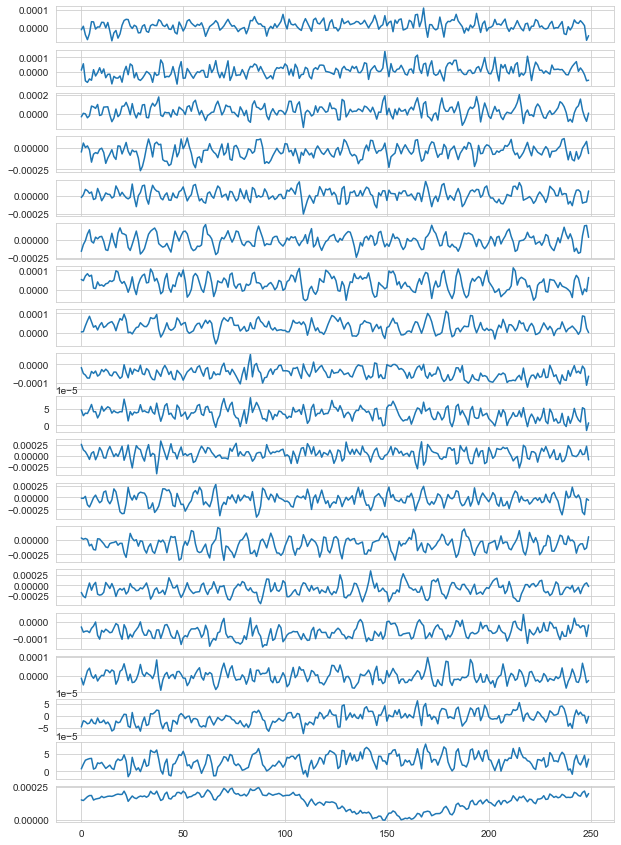

In [7]:
channels = 19
fig, axs = plt.subplots(nrows= channels,figsize=(10,15))

for i in range(channels):
    axs[i].plot(x[0][i])

# 2. VAE Implementation

## 2.1 Setting up the model

In [8]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        z=self.mu+self.sigma*self.sample_epsilon()
        return z

        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        normal_dist=torch.distributions.normal.Normal(self.mu,self.sigma)
        return normal_dist.log_prob(z) 

##### Implement a VAE as atorch.nn.Module.

(a)  Implement a method.encode(...)that encodes a batch ofx.

(b)  Implement a method.decode(...)that decodes a batch ofz.

(c)  Implement a method.sample(...)that generates samples.

(d)  Implement a method.elbo(...)that computes the ELBO

In [9]:
sample_x, sample_y = load()

In [10]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.RNNCell(input_size=self.observation_features,hidden_size=256),
            nn.Linear(in_features=256, out_features=256),
            nn.Tanh(),
            nn.RNNCell(input_size=256,hidden_size=128),
            #nn.Conv1d(in_channels=256,out_channels=256,kernel_size=5,stride=1,padding=2),       
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features)# <- note the 2*latent_features
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.Tanh(),
            nn.RNNCell(input_size=128,hidden_size=128),
            #nn.Conv1d(in_channels=128,out_channels=128,kernel_size=5,stride=1,padding=2),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.RNNCell(input_size=256,hidden_size=256),
            #nn.RNNCell(input_size=256,hidden_size=2*self.observation_features),
            nn.Linear(in_features=256, out_features=2*self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def sample(self, x:Tensor, z = False):
        loss, diagnostics, outputs = vi(vae, x)
        if z:
            pz = outputs['pz']   
            return pz.sample()
        px = outputs['px']
        return px.sample()

        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encode(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
     
        h_z = self.decoder(z)
        h_z = h_z.view(-1,*self.input_shape)       
        mu, log_sigma =  h_z.chunk(2, dim=0)
        sigma = log_sigma.exp()

        return torch.distributions.normal.Normal(mu, sigma)
      

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # define the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'z': z}

    def elbo(self,x:Tensor,beta=1):
        _, diagnostics, _ = vi(vae, x)

        return diagnostics['elbo']
    
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        self.test = px.sample()
        
        # evaluate log probabilities
        self.px_log = px.log_prob(x)
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo =log_px-kl # <- your code here
        beta_elbo =log_px-self.beta * kl # <- your code here
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

In [11]:
latent_features = 2
# Vi 
vi = VariationalInference(beta=1.0)

vae = VariationalAutoencoder(sample_x.size()[1:], latent_features)
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): RNNCell(4750, 256)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Tanh()
    (3): RNNCell(256, 128)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): RNNCell(128, 128)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): RNNCell(256, 256)
    (6): Linear(in_features=256, out_features=9500, bias=True)
  )
)


### (Report)Generate 64 samples from theuntrained modeland plot them on a 8×8 grid

In [12]:
untrained_samples = vae.sample(sample_x)

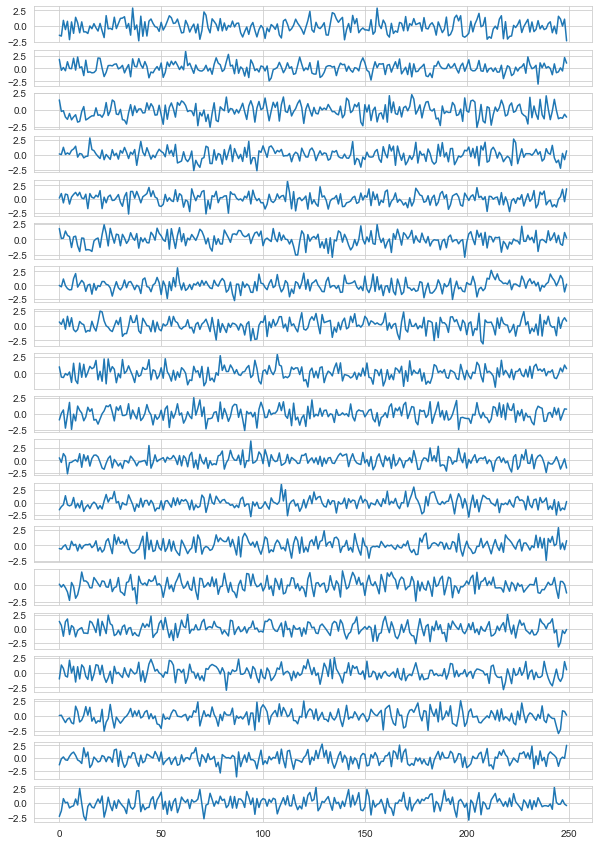

In [13]:
channels = 19
fig, axs = plt.subplots(nrows= channels,figsize=(10,15))

for i in range(channels):
    axs[i].plot(untrained_samples[0][i])

##### (Report)Compute the ELBO of 64 samples from thetraining setusing theuntrained modeland report the number.

In [14]:
elbo = vae.elbo(sample_x)

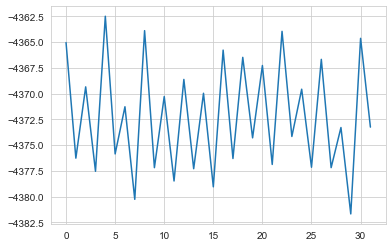

In [15]:
print("ELBO without training is: " + elbo[-1])

## 2.2 Setting up the training

In [16]:
from collections import defaultdict

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

# move the model to the device
vae = vae.to(device)

### 1. Implement a train(...)function that performs one epoch of training

In [17]:
def train(vae,n_batches= 10):
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for batch in range(n_batches):
        x,_ = load(batch_size= 60)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

    return training_epoch_data
            

### 2. Implement a test(...)function that evaluates the model on the test set.

In [18]:
def test(vae):
    global outputs,x,y
    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        x,y = load(batch_size= 60)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
        return validation_data


### 3. Train the model for some time (e.g.  100-200 epochs).  Remember to save the state dict of themodel using torch.save!

In [19]:
def cross_val():

        kl_interval = list(np.arange(0,2,0.15))
        
        logreg_gen_acc = np.zeros(len(kl_interval))
        
        n = len(kl_interval)
        
        for s in range(0, n):
                     
            vi = VariationalInference(beta=kl_interval[s])
            vae = VariationalAutoencoder(sample_x.size()[1:], latent_features)
            
            for epoch in range(20):
                training_epoch_data = train(vae)
            
            logreg_gen_acc[s] = np.mean(test(vae)['elbo'])
            print('Iteration number {0}/{1}. Error is {2}'.format(s,n, logreg_gen_acc[s]))
            
        logreg_max_acc = np.max(logreg_gen_acc)       
        opt_kl_index = np.argmax(logreg_gen_acc) 
        opt_kl = kl_interval[opt_kl_index]
       
        print('Accuracy - regularized log-reg - {0}'.format(np.round(logreg_max_acc, decimals = 3)))
        print('Optimal beta: {0}'.format(opt_kl))
        print()
        
        plt.plot(kl_interval,logreg_gen_acc, color = 'skyblue')
        plt.xlabel('beta')
        plt.ylabel('ELBO')
        plt.grid(True)

Iteration number 0/14. Error is -4375.37451171875
Iteration number 1/14. Error is -4375.878662109375
Iteration number 2/14. Error is -4376.454427083333
Iteration number 3/14. Error is -4375.495361328125
Iteration number 4/14. Error is -4375.46591796875
Iteration number 5/14. Error is -4375.314453125
Iteration number 6/14. Error is -4374.531598772322
Iteration number 7/14. Error is -4374.323486328125
Iteration number 8/14. Error is -4373.768446180556
Iteration number 9/14. Error is -4374.08896484375
Iteration number 10/14. Error is -4374.501775568182
Iteration number 11/14. Error is -4374.2969156901045
Iteration number 12/14. Error is -4374.167217548077
Iteration number 13/14. Error is -4374.267647879465
Accuracy - regularized log-reg - -4373.768
Optimal beta: 1.2



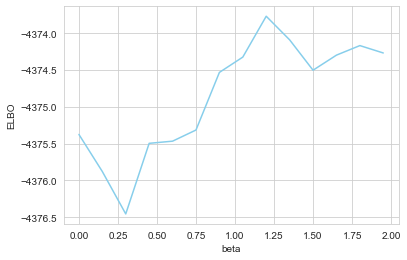

In [20]:
cross_val()

In [21]:
# Vi 
vi = VariationalInference(beta=1.2)

# vae
# vae = VariationalAutoencoder(sample_x.size()[1:], latent_features)

# move the model to the device
vae = vae.to(device)

[**SKIP the above if the training is finished. Just load the model.**]

In [22]:
# train
epoch = 0
num_epochs = 100
validation_data = defaultdict(list)
training_data = defaultdict(list)

while epoch < num_epochs:
    if epoch%10 == 0:
        print("Epoch {0}/{1}".format(epoch,num_epochs))
    epoch+= 1
    
    # gather data for the full epoch
    training_epoch_data = train(vae)
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    validation_data = test(vae)

Epoch 0/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100


In [23]:
# save model
path = "Saved_Models/vae.pt"
torch.save(vae.state_dict(), path)

**[END SKIP]**

In [24]:
'''
# train model
path = "Saved_Models/vae.pt"
vae.load_state_dict(torch.load(path))
'''

'\n# train model\npath = "Saved_Models/vae.pt"\nvae.load_state_dict(torch.load(path))\n'

### 4.(Report)Generate 64 samples from thetrained modeland plot them on a 8×8 grid.

In [25]:
trained_samples = vae.sample(sample_x)

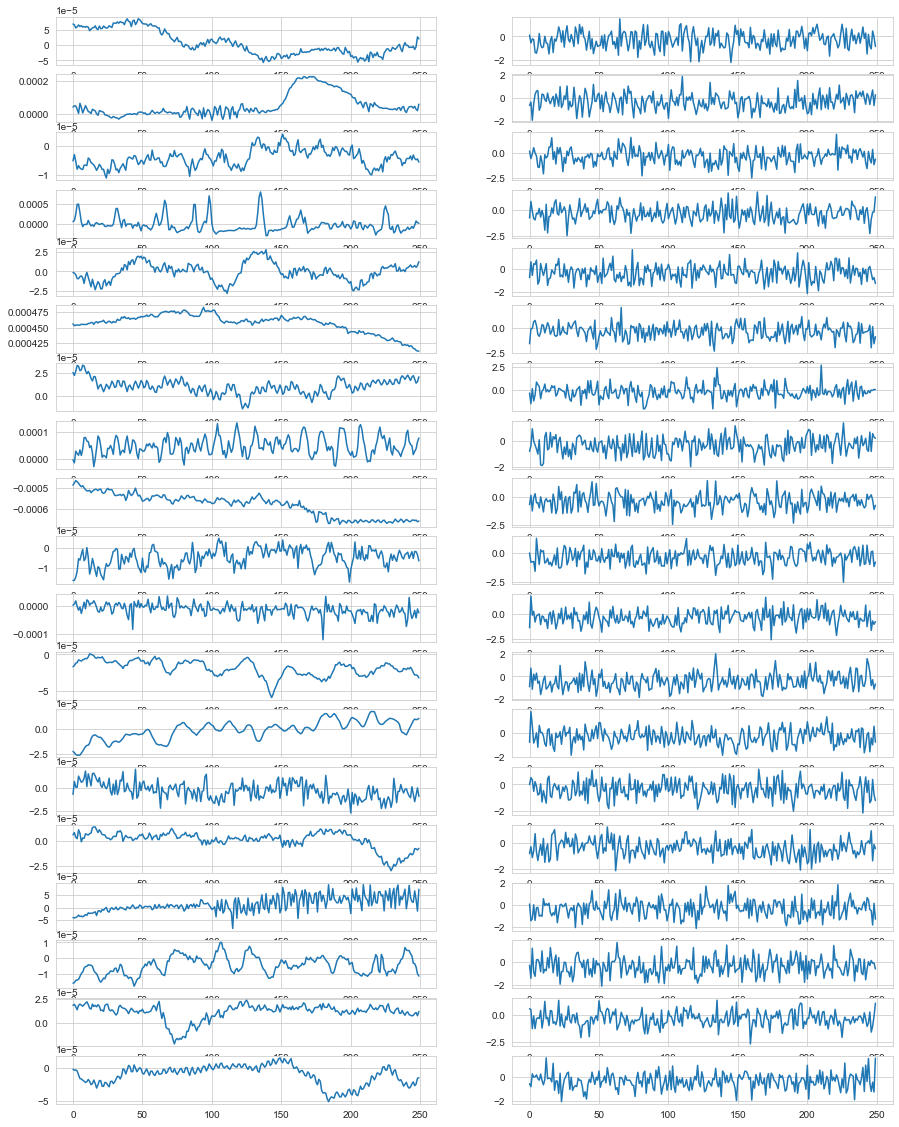

In [26]:
from torchvision.utils import make_grid

x_o = x

px = outputs['px']
x_sample = px.sample().to('cpu')
x_r = x_sample

channels = 19
fig, axs = plt.subplots(nrows= channels, ncols = 2,figsize=(15,20))

for i in range(channels):
    axs[i,0].plot(x_o[i][i])
    axs[i,1].plot(x_r[i][i])

### 5.(Report)Evaluate thetrained modelon the test set and report the number.

### Make a plots functions

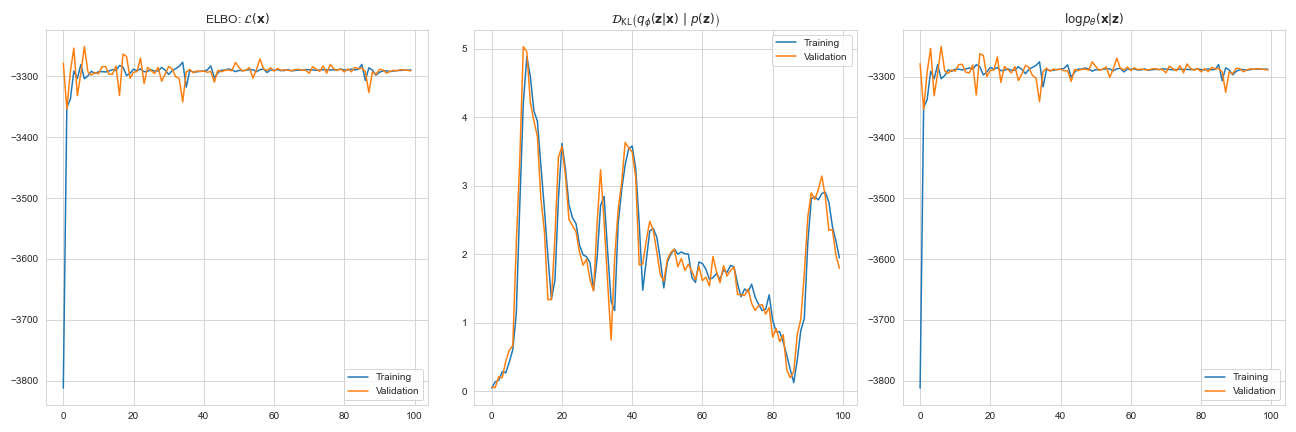

In [27]:
plot_AC(training_data, validation_data)

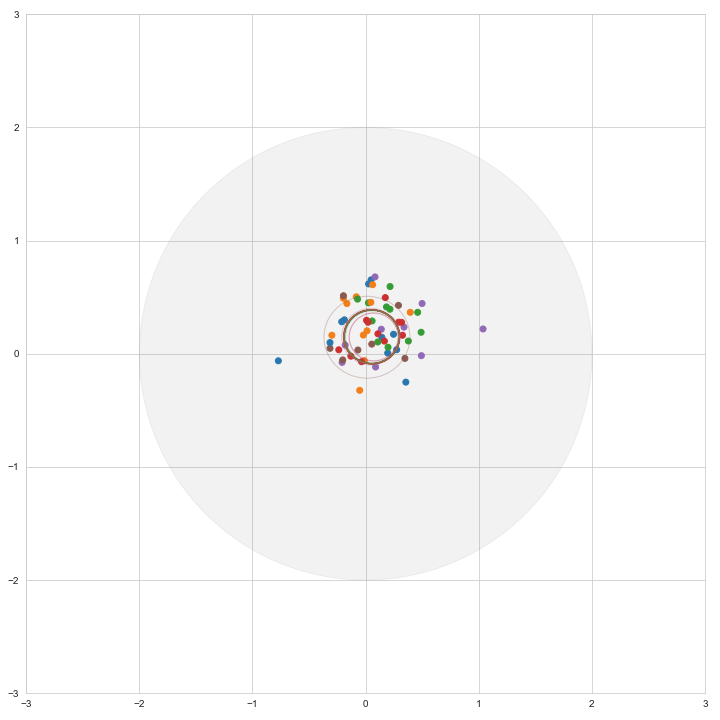

In [28]:
plot_2d_latents(outputs, y)

# 2.3  Semi-Supervised VAE (M1)

We have now trained a VAE on the full unlabeled dataset.  We will now implement the M1 modelfromSemi-Supervised Learning with Deep Generative Models. This amounts to simply traininga classifier on top of the representations learned by our VAE.

### 1.  Extract 100 labeled datapoints from MNIST (10 from each class).

In [29]:
x_train, y_train = load(batch_size = 6000)  
z_train = vae.sample(x_train, z = True)

### 2.(Report)Train a classifier on their latent representation.  First try a linear classifier and thenexperiment with other types of classifiers.  Report the accuracies.

In [30]:
x_test, y_test = load(batch_size = 600)
z_test = vae.sample(x_test, z = True)

In [31]:
x_valid, y_valid = load(batch_size = 120)  
z_valid = vae.sample(x_valid, z = True)

In [32]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
import seaborn as sn

def evaluate(y_true, y_pred, print_cm=False, print_err=False):
    
    # calculate and display confusion matrix
    labels = np.unique(y_true)
    names = ["null","eyem","chew","shiv","elpp","musc"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if print_cm:
        ax= plt.subplot()
        sn.heatmap(cm, annot=True, ax = ax, xticklabels=names, yticklabels=names, cmap = 'Reds', fmt = 'd')
        ax.set_xlabel('Predicted');
        ax.set_ylabel('True'); 

    # calculate precision, recall, and F1 score
    accuracy = float(np.trace(cm)) / np.sum(cm)
    precision = precision_score(y_true, y_pred, average=None, labels=labels)[1]
    recall = recall_score(y_true, y_pred, average=None, labels=labels)[1]
    f1 = 2 * precision * recall / (precision + recall)
    if print_err:
        print("")
        print("accuracy:", accuracy)
        print("precision:", precision)
        print("recall:", recall)
        print("f1 score:", f1)
        
    return [accuracy,precision,recall,f1]

### a) SVM

**[SKIP]** Skip this section if training is not needed.

In [33]:
from sklearn import svm

clf = svm.SVC() 
SVM = clf.fit(z_train,y_train)    

C:\Users\blanc\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [34]:

filename = 'Saved_Models/svm.pkl'
pickle.dump(SVM, open(filename, 'wb'))


**[END SKIP]**

In [35]:
'''
filename = 'Saved_Models/svm.pkl'
SVM = pickle.load(open(filename, 'rb'))
'''

"\nfilename = 'Saved_Models/svm.pkl'\nSVM = pickle.load(open(filename, 'rb'))\n"

**Evaluate**

In [36]:
y_pred = SVM.predict(z_test)

[0.17, 0.16981132075471697, 0.2621359223300971, 0.20610687022900764]

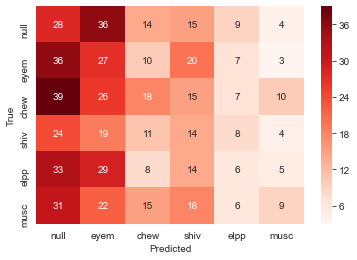

In [37]:
evaluate(y_test, y_pred, print_cm=True)

### b) Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF.fit(z_train,y_train)  

C:\Users\blanc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
y_pred = RF.predict(z_test)

[0.2, 0.18867924528301888, 0.1941747572815534, 0.19138755980861244]

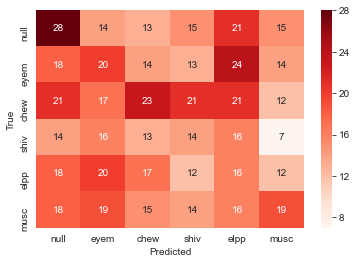

In [40]:
evaluate(y_test, y_pred, print_cm=True)

In [41]:

filename = 'Saved_Models/rf.pkl'
pickle.dump(RF, open(filename, 'wb'))


In [42]:
'''
filename = 'Saved_Models/rf.pkl'
RF = pickle.load(open(filename, 'rb'))
'''

"\nfilename = 'Saved_Models/rf.pkl'\nRF = pickle.load(open(filename, 'rb'))\n"

### C) Neural Network

In [43]:
#Hyperparameters
num_classes = 6
num_hidden_l1 = 500
num_hidden_l2 = 200
num_features = z_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_output):
        super(Net, self).__init__()  
        
        self.l_1 = Linear(in_features=num_features, 
                          out_features=num_hidden_l1,
                          bias=True)
        
        self.l_2 = Linear(in_features=num_hidden_l1, 
                          out_features=num_hidden_l2,
                          bias=True)
        
        self.l_out = Linear(in_features=num_hidden_l2, 
                            out_features=num_classes,
                            bias=False)

        self.drop_layer  = nn.Dropout(0.5) # Add dropout layer

        self.batchnorm_1 = nn.BatchNorm1d(num_hidden_l1)
        self.batchnorm = nn.BatchNorm1d(num_hidden_l1)

        # define activation function in constructor

    def forward(self, x):

        x = relu(self.l_1(x))
        x = relu(self.l_2(x))
       
        return softmax(self.l_out(x))

net = Net(num_features, num_classes)
print(net)

Net(
  (l_1): Linear(in_features=2, out_features=500, bias=True)
  (l_2): Linear(in_features=500, out_features=200, bias=True)
  (l_out): Linear(in_features=200, out_features=6, bias=False)
  (drop_layer): Dropout(p=0.5, inplace=False)
  (batchnorm_1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [44]:
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.05) # Add momentum
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-6) # use Adama instead # Use L2 regularization
criterion = nn.CrossEntropyLoss()

In [45]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 50
num_epochs = 100
num_samples_train = z_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = z_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(z_train[slce]).type(torch.float)
        y_pred = torch.argmax(output, dim =1)
        
        # compute gradients given loss
        target_batch = y_train[slce].type(torch.long)

        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(z_train[slce])
        y_pred = torch.argmax(output, dim =1)
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(y_pred.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(z_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(y_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

C:\Users\blanc\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch  0 : Train Loss 4.314282 , Train acc 0.166833, Valid acc 0.160000


KeyboardInterrupt: 

In [ ]:

filename = 'Saved_Models/fnn.pkl'
pickle.dump(net, open(filename, 'wb'))


In [ ]:
'''
filename = 'Saved_Models/fnn.pkl'
net = pickle.load(open(filename, 'rb'))
'''

In [ ]:
y_out = net(z_test)
y_pred = torch.argmax(y_out, dim =1)

In [ ]:
evaluate(y_test, y_pred, print_cm=True)